# Caverns with constraints

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from src import data as rd
from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

### Exclude only shipping routes, wind farms, and cables

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"shipping": shipping_b},
)

Without constraints...
Number of potential caverns: 4,169
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,847
Caverns excluded: 55.70%
------------------------------------------------------------
Exclude subsea cables...
No data specified!
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [13]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"cables": cables_b},
)

Without constraints...
Number of potential caverns: 4,169
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
No data specified!
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 3,974
Caverns excluded: 4.68%
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [14]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"wind_farms": wind_farms},
)

Without constraints...
Number of potential caverns: 4,169
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
No data specified!
------------------------------------------------------------
Exclude subsea cables...
No data specified!
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3,798
Caverns excluded: 8.90%
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


### Exclude all

In [15]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,169
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 4,084
Caverns excluded: 2.04%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,776
Caverns excluded: 57.40%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,708
Caverns excluded: 59.03%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 67.67%
---------------------------------------------------

In [16]:
caverns.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,1348.000000,1348.000000
mean,301.489553,1023.723872
std,82.261457,406.460427
min,175.062400,420.214316
25%,236.640675,693.493665
50%,289.841300,944.108660
75%,353.043800,1324.723435
max,754.985800,1919.031682


In [17]:
# excluded areas
caverns_excl.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,2821.00000,2821.000000
mean,293.20813,880.182815
std,94.10839,346.958662
min,175.05550,420.504527
25%,231.87920,615.516654
50%,269.28580,781.140783
75%,329.25700,1090.262820
max,992.17940,1909.983075


In [18]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Crop data layers

In [19]:
# land boundary
land = rd.read_shapefile_from_zip(
    data_path=os.path.join(
        "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
    )
)

land = land.dissolve().to_crs(rd.CRS)

In [20]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [21]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [22]:
# # merge salt edge buffer
# buffer_edge = pd.concat(buffer_edge.values()).dissolve()

## Maps

In [23]:
def plot_map(dat_xr):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest
    """

    # initialise figure
    plt.figure(figsize=(12, 8))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))

    # # configure colour bar based on variable
    # if var == "TopTWT":
    #     units = "ms"
    # else:
    #     units = "m"
    # cbar_label = f"{dat_xr[var].attrs['long_name']} [{units}]"
    # if stat == "max":
    #     plot_data = dat_xr.max(dim="halite", skipna=True)
    #     cbar_label = f"Maximum Halite {cbar_label}"
    # elif stat == "min":
    #     plot_data = dat_xr.min(dim="halite", skipna=True)
    #     cbar_label = f"Minimum Halite {cbar_label}"
    # elif stat == "mean":
    #     plot_data = dat_xr.mean(dim="halite", skipna=True)
    #     cbar_label = f"Mean Halite {cbar_label}"

    # # plot halite data
    # plot_data[var].plot.contourf(
    #     cmap="jet", alpha=.65, robust=True, levels=15,
    #     cbar_kwargs={"label": cbar_label}
    # )

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    # plt.xlim(xmin - 1450, xmax + 500)
    # plt.ylim(ymin - 500, ymax + 500)
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor=sns.color_palette("flare", 4)[-2],
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Kish Basin boundary",
            edgecolor=sns.color_palette("flare", 4)[-2],
        )
    )

    # add constraint layers
    for df, color, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["slategrey", sns.color_palette("GnBu", 10)[-1]],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis, facecolor="none", hatch="//", edgecolor=color, zorder=1
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="//", edgecolor=color, label=label
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        [sns.color_palette("GnBu", 10)[-4], sns.color_palette("flare", 4)[0]],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    cx.add_basemap(axis, crs=rd.CRS, source=cx.providers.CartoDB.Voyager)
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

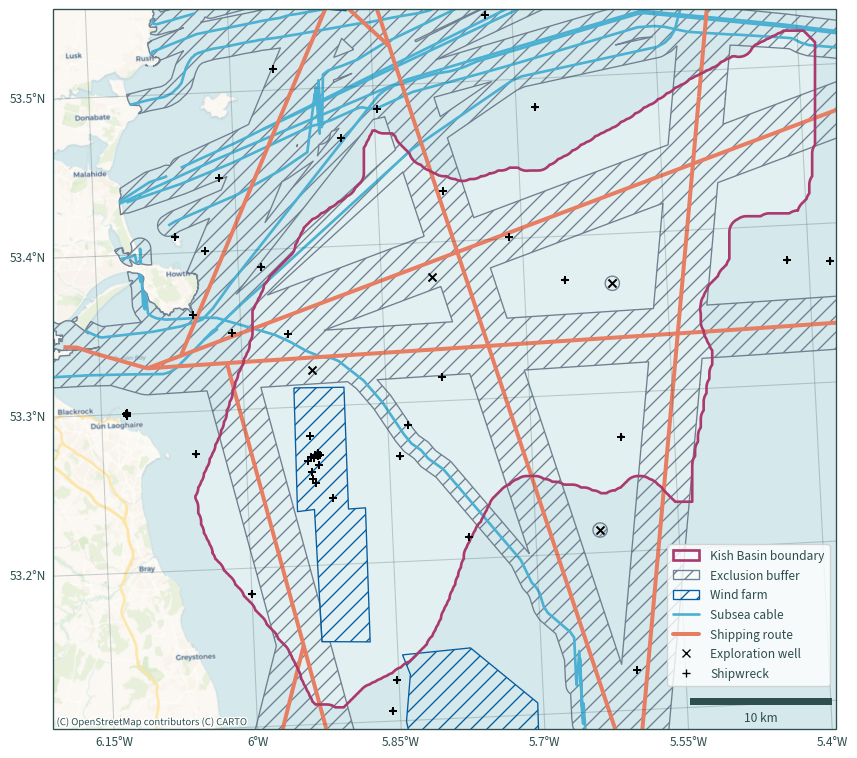

In [20]:
plot_map(ds)

In [24]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    for df, markersize in zip(
        [
            cavern_df[cavern_df["depth"] == "500 - 1,000"],
            cavern_df[cavern_df["depth"] == "1,000 - 1,500"],
            cavern_df[cavern_df["depth"] == "1,500 - 2,000"],
        ],
        [20, 50, 20],
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=axis,
            column="Thickness",
            zorder=3,
            markersize=markersize,
            cmap=sns.color_palette("flare", as_cmap=True),
            linewidth=0,
            marker=".",
            scheme="UserDefined",
            classification_kwds={"bins": [155 + 90, 311 + 90]},
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    palette = [
        sns.color_palette("flare", 256)[0],
        sns.color_palette("flare", 256)[127],
        sns.color_palette("flare", 256)[-1],
    ]
    for color, label in zip(palette, ["85", "155", "311"]):
        # legend_handles.append(
        #     Line2D(
        #         [0], [0], marker="o", linewidth=0, label=label, color=color
        #     )
        # )
        legend_handles.append(mpatches.Patch(facecolor=color, label=label))
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=11.5,
    )

    plt.tight_layout()
    plt.show()

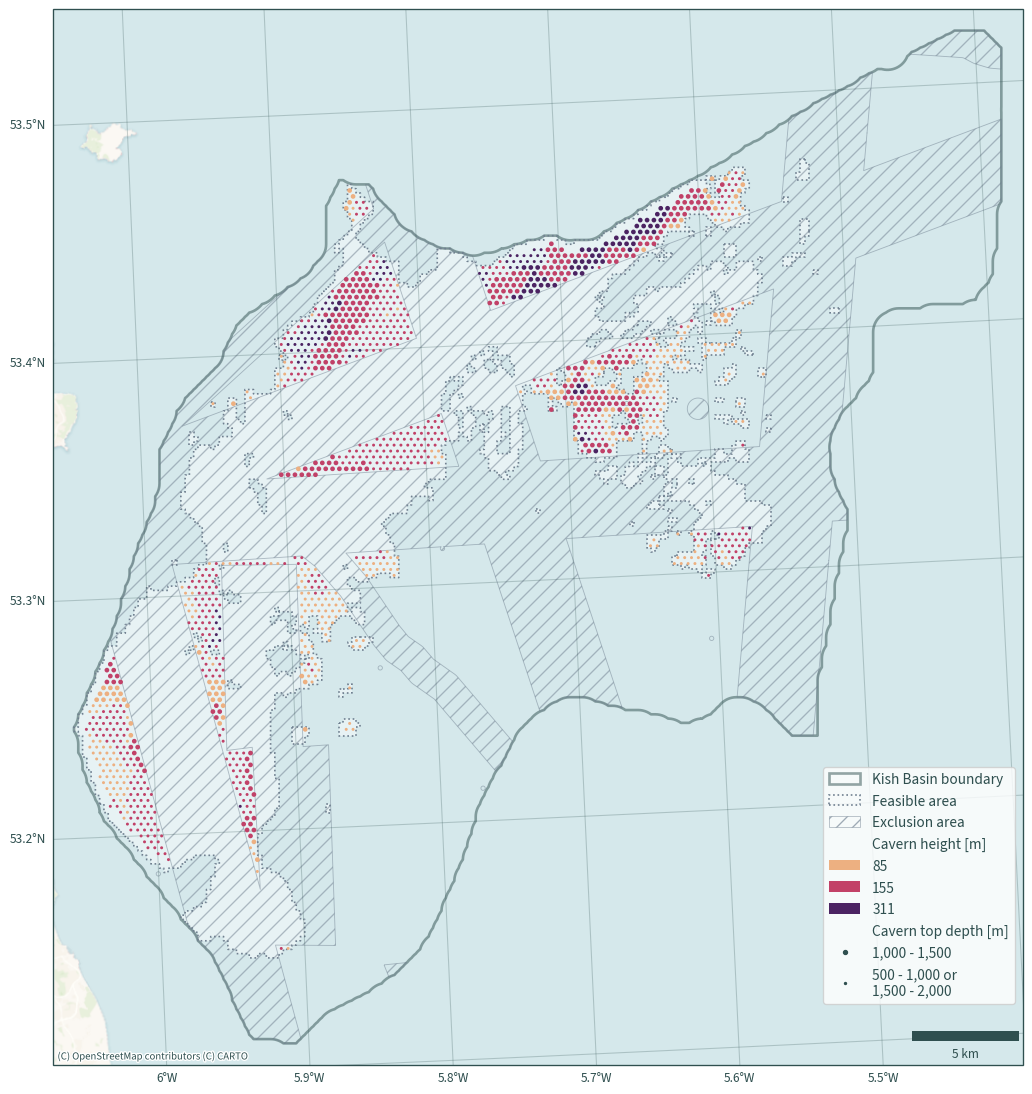

In [25]:
plot_map_alt(ds, caverns, zones)

## Stats

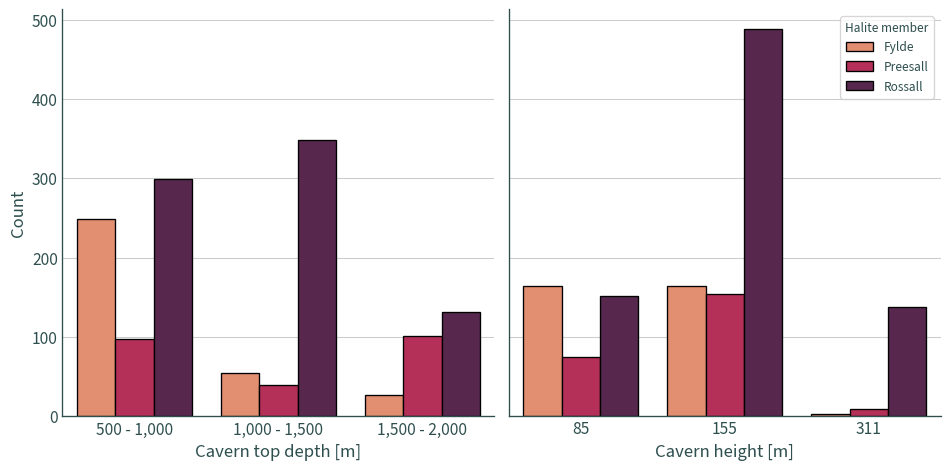

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[0],
    x="depth",
    hue="halite",
    palette="rocket_r",
    legend=False,
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
axes[0].set_xlabel("Cavern top depth [m]")
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[1],
    x="height",
    hue="halite",
    palette="rocket_r",
    order=["85", "155", "311"],
    edgecolor="black",
)
axes[1].set_xlabel("Cavern height [m]")
axes[0].set_ylabel("Count")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
plt.legend(title="Halite member")
sns.despine()
plt.tight_layout()
plt.show()

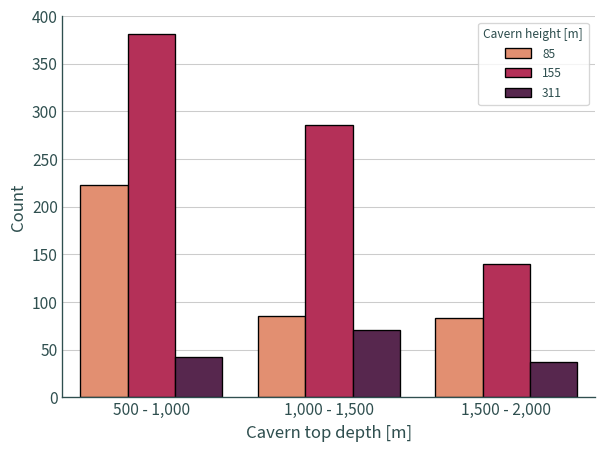

In [27]:
ax = sns.countplot(
    caverns.sort_values("Thickness"),
    x="depth",
    hue="height",
    palette="rocket_r",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
ax.set_xlabel("Cavern top depth [m]")
ax.set_ylabel("Count")
ax.grid(which="major", axis="y")
sns.despine()
plt.legend(title="Cavern height [m]")
plt.tight_layout()
plt.show()

In [28]:
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
height,,
85,391,29.005935
155,807,59.866469
311,150,11.127596


In [29]:
s = (
    caverns.sort_values("TopDepthSeabed")
    .groupby("depth", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
depth,,
"500 - 1,000",646,47.922849
"1,000 - 1,500",442,32.789318
"1,500 - 2,000",260,19.287834


In [30]:
s = caverns.groupby(["height", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
height depth                             
311    1,000 - 1,500        71   5.267062
       500 - 1,000          42   3.115727
       1,500 - 2,000        37   2.744807
155    1,000 - 1,500       286  21.216617
       1,500 - 2,000       140  10.385757
       500 - 1,000         381  28.264095
85     1,000 - 1,500        85   6.305638
       1,500 - 2,000        83   6.157270
       500 - 1,000         223  16.543027